### Amazon Book Recommendation System Utilizing Product Co-Purchasing Network Metadata

### Import required libraries

In [34]:
# Standard library imports
import re
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stemming.porter2 import stem
import networkx as nx
import stemming
from IPython.display import Image
import string

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reshm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reshm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Dataset Preprocessing





In [35]:
# Function to clean and process categories
def clean_categories(categories):
    categories = categories.lower()  # Convert to lowercase
    categories = re.sub(r'[\d{}]+'.format(string.punctuation), ' ', categories)  # Remove digits and punctuation
    categories = ' '.join(set(categories.split()) - set(stopwords.words("english")))  # Remove stopwords
    return ' '.join(stem(word) for word in categories.split())  # Stem words

# Function to parse metadata from Amazon file
def parse_metadata(file_path):
    amazon_products = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        metadata = {}
        for line in f:
            line = line.strip()
            if line.startswith("Id"):
                if metadata:
                    amazon_products[metadata['ASIN']] = metadata
                    metadata = {}
                metadata['Id'] = line.split(':', 1)[1].strip()
            elif line.startswith("ASIN"):
                metadata['ASIN'] = line.split(':', 1)[1].strip()
            elif line.startswith("title"):
                metadata['Title'] = ' '.join(line.split(':', 1)[1].strip().split())
            elif line.startswith("group"):
                metadata['Group'] = line.split(':', 1)[1].strip()
            elif line.startswith("salesrank"):
                metadata['SalesRank'] = int(line.split(':', 1)[1].strip())
            elif line.startswith("similar"):
                metadata['Copurchased'] = ' '.join(line.split(':', 1)[1].strip().split()[1:])
            elif line.startswith("categories"):
                num_categories = int(line.split(':', 1)[1].strip())
                categories = ' '.join(next(f).strip().lower() for _ in range(num_categories))
                metadata['Categories'] = clean_categories(categories)
            elif line.startswith("reviews"):
                parts = line.split()
                metadata['TotalReviews'] = int(parts[2])
                metadata['AvgRating'] = float(parts[7])
    return amazon_products

# Parse Amazon metadata and store in a dictionary
amazon_products = parse_metadata('../amazon-meta.txt')

### Filtering out book products from the metadata (group == Book)

In [36]:
# Create a book-specific dictionary containing only books from the Amazon products
book_products = {}

# Iterate through each ASIN and its metadata in the Amazon products
for asin, metadata in amazon_products.items():
    # Check if the product belongs to the 'Book' group (if 'Group' key exists in metadata)
    if metadata.get('Group') == 'Book':
        # Add the book to the book-specific dictionary
        book_products[asin] = metadata

# Remove any co-purchased items from the co-purchase list if their metadata is not available
for asin, metadata in book_products.items():
    # Split the co-purchase list into individual ASINs
    copurchased_asins = metadata['Copurchased'].split()
    
    # Filter out ASINs that are not present in the book-specific dictionary
    copurchased_asins = [cp for cp in copurchased_asins if cp in book_products]
    
    # Update the co-purchase list with filtered ASINs
    metadata['Copurchased'] = ' '.join(copurchased_asins)


### Display the formatted book data 

In [37]:
book_products['059035342X']

{'Id': '148185',
 'ASIN': '059035342X',
 'Title': "Harry Potter and the Sorcerer's Stone (Book 1)",
 'Group': 'Book',
 'SalesRank': 746,
 'Copurchased': '0439064864 0439136350 0439139600 043935806X',
 'Categories': 'paperback author k scienc magic illustr general horror literatur subject harri potter z seri fiction fantasi children age r j humor book adventur mysteri rowl',
 'TotalReviews': 5034,
 'AvgRating': 5.0}

To construct the copurchase graph structure from the copurchase data in the Amazon books dictionary, follow these steps:

Nodes: Represented by ASINs (Amazon Standard Identification Numbers).

Edges: Connect two nodes if the corresponding ASINs were co-purchased by customers.

Edge Weight: Determined by category similarity between the co-purchased items.

Similarity Calculation: Measure the similarity between any two ASINs based on their co-purchased categories. This can be calculated by counting the number of words that are common between the categories of the connected nodes, and then dividing by the total number of words in both categories. The resulting similarity value ranges from 0 (indicating the highest dissimilarity) to 1 (indicating the highest similarity).

### Generate a copurchase graph for product analysis using Jaccard Similarity

In [38]:
# Initialize a graph for representing copurchase relationships
copurchase_graph = nx.Graph()

# Iterate through each book ASIN and its metadata
for asin, metadata in book_products.items():
    # Add the ASIN as a node in the copurchase graph
    copurchase_graph.add_node(asin)
    
    # Iterate through each copurchased ASIN in the metadata
    for copurchased_asin in metadata['Copurchased'].split():
        copurchased_asin = copurchased_asin.strip()  # Remove leading/trailing whitespace
        
        # Add the copurchased ASIN as a node in the copurchase graph
        copurchase_graph.add_node(copurchased_asin)
        
        # Calculate the category similarity between the current book ASIN and the copurchased ASIN
        similarity = 0
        categories1 = set(metadata['Categories'].split())  # Categories of the current book
        categories2 = set(book_products[copurchased_asin]['Categories'].split())  # Categories of the copurchased book
        
        # Calculate the intersection and union of categories
        common_categories = categories1 & categories2  # Common categories
        total_categories = categories1 | categories2  # Total categories
        
        # Calculate the similarity based on category intersection and union
        if total_categories:
            similarity = round(len(common_categories) / len(total_categories), 2)
        
        # Add an edge between the current book ASIN and the copurchased ASIN with the calculated similarity as weight
        copurchase_graph.add_edge(asin, copurchased_asin, weight=similarity)


### Incorporating Graph Metrics into AmazonBooks Metadata

In [39]:
# Calculate degree centrality and clustering coefficients for each node
degree_centrality = nx.degree(copurchase_graph)

# Iterate through each ASIN in the copurchase graph
for asin in nx.nodes(copurchase_graph):
    # Retrieve metadata for the current ASIN from the book_products dictionary
    metadata = book_products[asin]
    
    # Add degree centrality to the metadata
    metadata['DegreeCentrality'] = int(degree_centrality[asin])
    
    # Create an ego graph centered around the current ASIN with a radius of 1
    ego_graph = nx.ego_graph(copurchase_graph, asin, radius=1)
    
    # Calculate the clustering coefficient for the ego graph and round it to two decimal places
    clustering_coefficient = round(nx.average_clustering(ego_graph), 2)
    
    # Add clustering coefficient to the metadata
    metadata['ClusteringCoefficient'] = clustering_coefficient
    
    # Update metadata in the book_products dictionary with degree centrality and clustering coefficient
    book_products[asin] = metadata


### Exporting Amazon Books Data and Copurchase Graph


In [40]:
# Write AmazonBooks data to file
with open('./amazon-books.txt', 'w', encoding='utf-8', errors='ignore') as file:
    # Write header with column names
    file.write('Id\tASIN\tTitle\tCategories\tGroup\tCopurchased\tSalesRank\tTotalReviews\tAvgRating\tDegreeCentrality\tClusteringCoefficient\n')
    
    # Iterate over each ASIN and its metadata in the book_products dictionary
    for asin, metadata in book_products.items():
        # Write metadata values to file, separated by tabs
        file.write('\t'.join([
            metadata['Id'],
            asin,
            metadata['Title'],
            metadata['Categories'],
            metadata['Group'],
            metadata['Copurchased'],
            str(metadata['SalesRank']),
            str(metadata['TotalReviews']),
            str(metadata['AvgRating']),
            str(metadata['DegreeCentrality']),
            str(metadata['ClusteringCoefficient'])
        ]) + '\n')

# Write copurchaseGraph to file
with open('amazon-books-copurchase.edgelist', 'wb') as file:
    # Write the copurchase graph as a weighted edgelist to the file
    nx.write_weighted_edgelist(copurchase_graph, file)


### Data Loading and Graph Initialization

In [41]:
# Open the Amazon books data file for reading
books_file = open('amazon-books.txt', 'r', encoding='utf-8', errors='ignore')

# Initialize a dictionary to store book metadata
books = {}

# Skip the header line
books_file.readline()

# Read each line in the file and extract book metadata
for line in books_file:
    # Split the line into cells using tab delimiter
    cells = line.split("\t")
    
    # Initialize a dictionary to store metadata for each book
    metadata = {}
    
    # Extract metadata from each cell and store in the metadata dictionary
    metadata['Id'] = cells[0].strip()
    asin = cells[1].strip()
    metadata['Title'] = cells[2].strip()
    metadata['Categories'] = cells[3].strip()
    metadata['Group'] = cells[4].strip()
    metadata['Copurchased'] = cells[5].strip()
    metadata['SalesRank'] = int(cells[6].strip())
    metadata['TotalReviews'] = int(cells[7].strip())
    metadata['AvgRating'] = float(cells[8].strip())
    metadata['DegreeCentrality'] = int(cells[9].strip())
    metadata['ClusteringCoefficienticient'] = float(cells[10].strip())
    
    # Add the book metadata to the books dictionary using ASIN as the key
    books[asin] = metadata

# Close the Amazon books data file
books_file.close()

# Open the copurchase graph file for reading
graph_file = open("amazon-books-copurchase.edgelist", "rb")

# Read the copurchase graph from the file
copurchase_graph = nx.read_weighted_edgelist(graph_file)

# Close the copurchase graph file
graph_file.close()


### Input an ASIN for which recommendation are to be generated.


In [42]:
print("---------------------------------------------------------------")
print("                Book bought by the customer          ")
print("---------------------------------------------------------------")

Purchased_ASIN = input("Enter the ASIN for which recommendation are to be generated")
print("\nBook Details:")
print(" ASIN:             ", Purchased_ASIN)
print(" Title:            ", books[Purchased_ASIN]['Title'])
print(" Sales Rank:       ", books[Purchased_ASIN]['SalesRank'])
print(" Total Reviews:    ", books[Purchased_ASIN]['TotalReviews'])
print(" Average Rating:   ", books[Purchased_ASIN]['AvgRating'])
print(" Degree Centrality:", books[Purchased_ASIN]['DegreeCentrality'])
print(" Clustering Coeff: ", books[Purchased_ASIN]['ClusteringCoefficient'])
print("\n---------------------------------------------------------------")

---------------------------------------------------------------
                Book bought by the customer          
---------------------------------------------------------------

Book Details:
 ASIN:              


KeyError: ''

### Generate Ego Graph

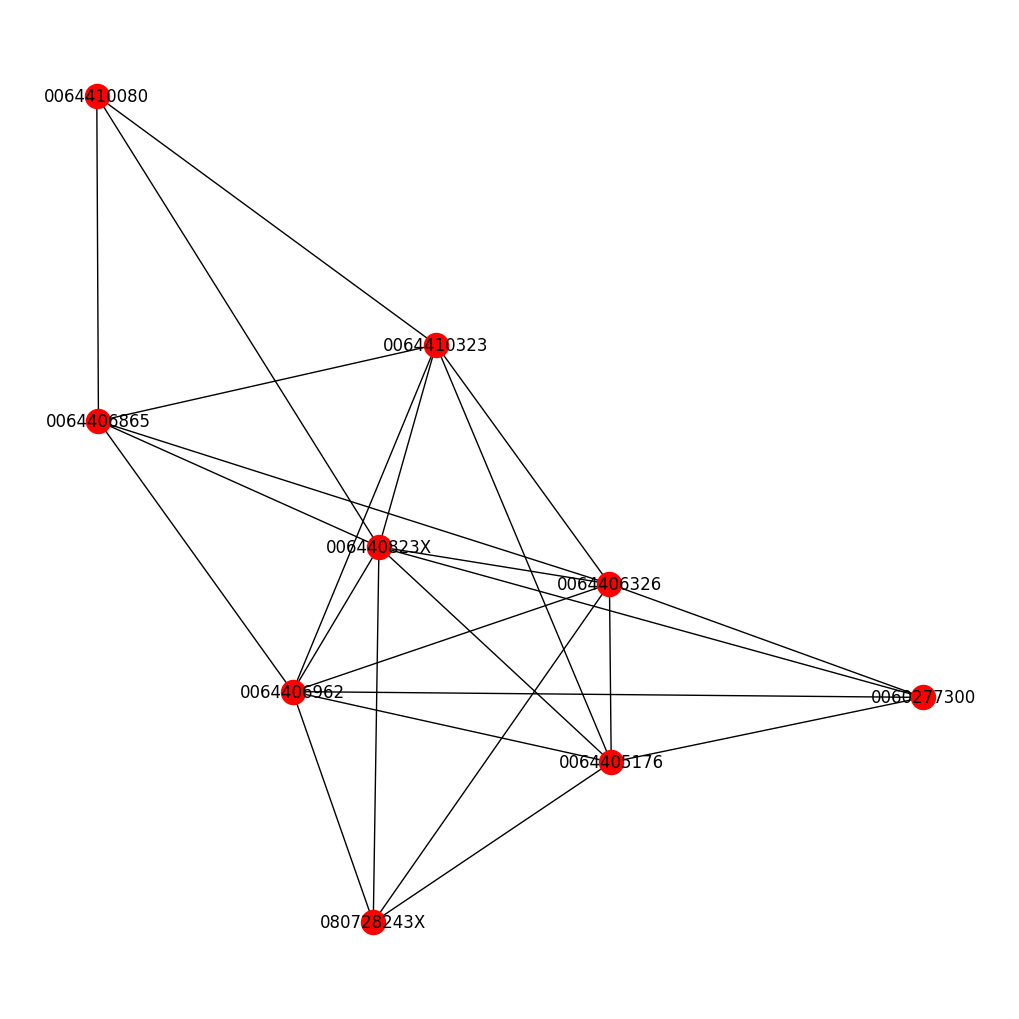

In [ ]:

# Generate ego graph for the purchased book
ego = nx.ego_graph(copurchase_graph, Purchased_ASIN, radius=1)
Purchased_ASIN_Ego_Graph = nx.Graph(ego)

# Set figure size and layout for visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(Purchased_ASIN_Ego_Graph)

# Visualize the ego graph
nx.draw(Purchased_ASIN_Ego_Graph, pos, node_color='red', node_size=300, with_labels=True)

# Display the graph
plt.show()


###  Book Recommendations Based on Category Similarity

In [ ]:
# Set similarity threshold for category-based similarity measure
threshold = 0.5 

# Initialize an empty graph to store trimmed ego graph based on similarity threshold
Purchased_ASIN_Ego_Trim_Graph = nx.Graph()

# Iterate through edges of ego graph to filter edges based on similarity threshold
for f, t, e in Purchased_ASIN_Ego_Graph.edges(data=True):
    if e['weight'] >= threshold:
        Purchased_ASIN_Ego_Trim_Graph.add_edge(f, t)

# Get neighbors of the purchased book in the trimmed ego graph
Purchased_ASIN_Neighbors = Purchased_ASIN_Ego_Trim_Graph.neighbors(Purchased_ASIN)

# Initialize a list to store metadata of similar books
ASIN_Meta = []

# Extract metadata for each neighbor book
for asin in Purchased_ASIN_Neighbors:
    ASIN = asin
    Title = book_products[ASIN]['Title']
    SalesRank = book_products[ASIN]['SalesRank']
    TotalReviews = book_products[ASIN]['TotalReviews']
    AvgRating = book_products[ASIN]['AvgRating']
    DegreeCentrality = book_products[ASIN]['DegreeCentrality']
    ClusteringCoefficient = book_products[ASIN]['ClusteringCoefficient']
    ASIN_Meta.append((ASIN, Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoefficient))


### Recommended Books

In [ ]:
import heapq

# Get top 5 recommendations based on average rating and total reviews
Top5_ByAbgRating_ThenByTotalReviews = heapq.nlargest(5, ASIN_Meta, key=lambda x: (x[4], x[3]))

print("\nTop 5 Picks for Customers Who Bought This Book:")
print("--------------------------------------------------------------------------------------")
print("{:<12} {:<40} {:<12} {:<12} {:<12} {:<18} {:<15}".format('ASIN', 'Title', 'SalesRank', 'TotalReviews', 'AvgRating', 'DegreeCentrality', 'ClusteringCoefficient'))
for asin in Top5_ByAbgRating_ThenByTotalReviews:
    print("{:<12} {:<40} {:<12} {:<12} {:<12} {:<18} {:<15}".format(asin[0], asin[1][:40], asin[2], asin[3], asin[4], asin[5], asin[6]))

print()


Top 5 Picks for Customers Who Bought This Book:
--------------------------------------------------------------------------------------
ASIN         Title                                    SalesRank    TotalReviews AvgRating    DegreeCentrality   ClusteringCoeff
0064405176   Walk Two Moons                           1466         592          4.5          47                 0.68           
0064406962   Chasing Redbird                          22128        155          4.5          8                  0.83           
080728243X   The Wanderer                             331098       150          4.5          4                  1.0            
0064406326   Absolutely Normal Chaos                  24183        122          4.5          12                 0.8            
0064406865   Pleasing the Ghost                       223424       39           4.0          7                  0.8            

